# Akbank Derin Öğrenme Bootcamp - Pneumonia Hastalığı Tahmini 

## İçindekiler
1. [**Proje Hakkında**](#1)  
2. [**Hiperparametre Optimizasyonu**](#2)  
3. [**Veri Yükleme** ](#3)
4. [**Veri Görselleştirme** ](#4)  
5. [**Veri Önişleme ve Hazırlık**](#5)
6. [**Model Tasarımı ve Eğitimi**](#6)
7. [**Model Değerlendirmesi**](#7)

***

## 1. Proje Hakkında
<a id="1"></a>

### 1.1 Proje Amacı

    Sorun Tanımı
    Göğüs röntgeni görüntülerinden pnömoni teşhisi koymak, radyolojistler için zaman alıcı ve uzmanlık gerektiren bir süreçtir. Manuel değerlendirme süreçleri hem zaman kaybına hem de insan kaynaklı hatalara yol açabilmektedir. Mevcut binlerce göğüs röntgeni görüntüsünün manuel olarak değerlendirilmesi önemli bir iş yükü oluşturmaktadır.

    Görevim
    Bu proje kapsamında, göğüs röntgeni görüntülerinden pnömoni varlığını otomatik tespit edebilen bir CNN modeli geliştirmeyi planlıyorum. 5,863 adet röntgen görüntüsü kullanarak NORMAL ve PNEUMONIA sınıfları arasında tahmin yapan bir model oluşturacağım.

### 1.2 Veri Seti Bilgisi

    Temel Özellikler
    * Veri Seti: Chest X-Ray Images (Pneumonia)
    * Toplam Görüntü: 5,863 adet JPEG röntgen görüntüsü
    * Sınıflar: 2 sınıf (NORMAL, PNEUMONIA)
    * Bölümler: train, test, validation setleri

    Kaynak ve Kalite:
    * Hastane: Guangzhou Women and Children's Medical Center* 
    * Yaş Grubu: 1-5 yaş pediatrik hastalar
    * Doğrulama: İki uzman hekim tarafından etiketlenmiş
    * Veri Seti: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia

***


## 2. Hiperparametre Optimizasyonu
<a id="2"></a>

    Gerekli olduğunu düşünüğüm tüm kütüphanleri ekledim.

In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.utils import image_dataset_from_directory
from keras.layers import Conv2D, MaxPool2D, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.layers import RandomFlip, RandomRotation, RandomZoom, RandomContrast
from keras.preprocessing import image
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import seaborn as sns
import keras
import cv2
import os
import warnings
warnings.filterwarnings('ignore')
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3" 

print("TensorFlow version:", tf.__version__)
print("GPU available:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.18.0
GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


    İlk olarak modelimin en iyi sonuç veren hiperparametreleri bulmakla başlamak istedim. Çünkü ilerideki adımlarda aklımda soru işreti kalmasını istemedim.

    Bu aşamada farklı optimizatörlerin (SGD, Momentum, Adam, RMSprop) performanslarını karşılaştırarak modelimin doğruluk oranları üzerindeki etkilerini gözlemledim.


In [4]:
def comparison_of_optimizers():
    def prepare_data():
        train_ds = tf.keras.preprocessing.image_dataset_from_directory(
            '/kaggle/input/chest-xray-pneumonia/chest_xray/train',
            image_size=(150, 150),
            batch_size=1000,
            label_mode='binary',
            color_mode='grayscale'
        )
        
        X, y = [], []
        for images, labels in train_ds:
            X.append(images.numpy())
            y.append(labels.numpy())
        
        X = np.concatenate(X, axis=0)
        y = np.concatenate(y, axis=0)
        
        X = X / 255.0
        
        print(f"X shape: {X.shape}, y shape: {y.shape}")
        return X, y
    
    X, y = prepare_data()
    
    optimizers = {
        'SGD': keras.optimizers.SGD(learning_rate=0.001),
        'Momentum': keras.optimizers.SGD(learning_rate=0.001, momentum=0.9),
        'Adam': keras.optimizers.Adam(learning_rate=0.001),
        'RMSprop': keras.optimizers.RMSprop(learning_rate=0.001)
    }
    
    plt.figure(figsize=(12, 8))
    
    for opt_name, optimizer in optimizers.items():
        # CNN modeli oluştur
        model = keras.Sequential([
            keras.layers.Conv2D(32, 3, activation='relu', input_shape=(150, 150, 1)),
            keras.layers.MaxPooling2D(),
            keras.layers.Conv2D(64, 3, activation='relu'),
            keras.layers.MaxPooling2D(),
            keras.layers.Flatten(),
            keras.layers.Dense(64, activation='relu'),
            keras.layers.Dense(1, activation='sigmoid')
        ])
    
        model.compile(optimizer=optimizer,
                     loss='binary_crossentropy',
                     metrics=['accuracy'])
    
        history = model.fit(X, y, epochs=50, batch_size=32, verbose=0, validation_split=0.2)
    
        plt.plot(history.history['val_accuracy'], label=opt_name, linewidth=2)
        print(f"{opt_name}: Final Val Acc = {history.history['val_accuracy'][-1]:.4f}")
    
    plt.title('Optimizer Karşılaştırması', fontsize=16, fontweight='bold')
    plt.xlabel('Epoch')
    plt.ylabel('Doğruluk')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

Found 5216 files belonging to 2 classes.


I0000 00:00:1758812138.871551      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


X shape: (5216, 150, 150, 1), y shape: (5216, 1)


I0000 00:00:1758812158.195755     102 service.cc:148] XLA service 0x7ee020005c50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1758812158.196443     102 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1758812158.381762     102 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1758812160.479192     102 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


SGD: Final Val Acc = 0.9502
Momentum: Final Val Acc = 0.9674
Adam: Final Val Acc = 0.9808
RMSprop: Final Val Acc = 0.9789


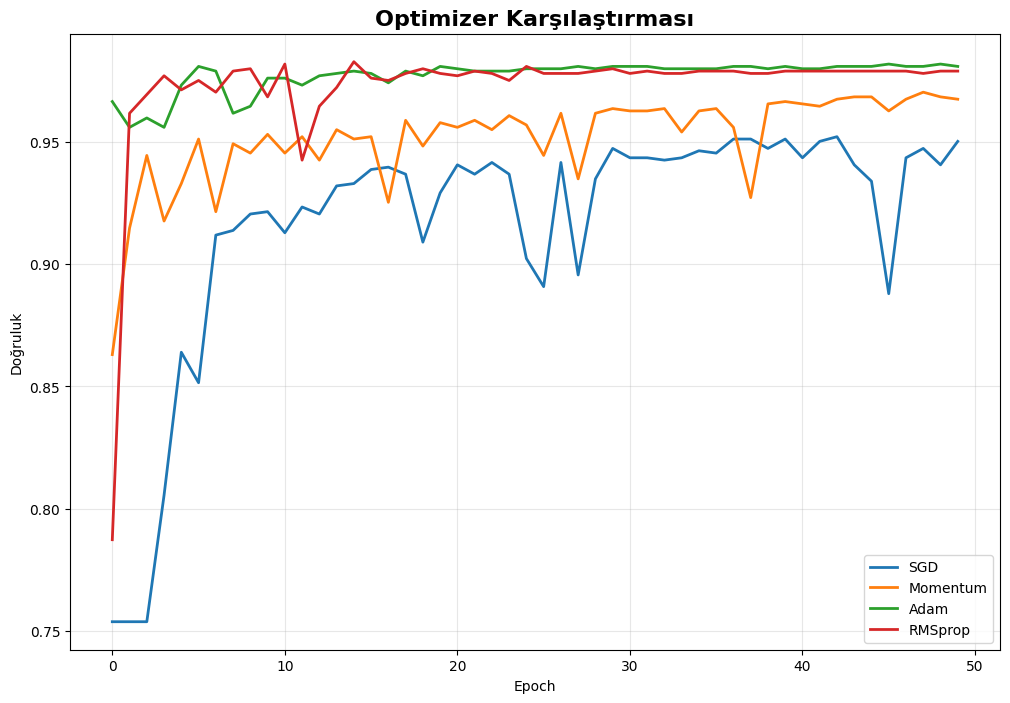

In [5]:
comparison_of_optimizers()

    En iyi sonuç veren optimizatörlerin Adam ve RMSsprop olarak karşıma çıktı. Ancak 10. epochta RMSsprop'un ani düşüşü yüzünden Adam ile devam ettim.

In [6]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

def hyperparameter_optimization(img_size):
    def prepare_data():
        train_ds = tf.keras.preprocessing.image_dataset_from_directory(
            '/kaggle/input/chest-xray-pneumonia/chest_xray/train',
            image_size=(img_size, img_size),
            batch_size=1000,
            label_mode='binary',
            color_mode='grayscale'
        )
        
        X, y = [], []
        for images, labels in train_ds:
            X.append(images.numpy())
            y.append(labels.numpy())
        
        X = np.concatenate(X, axis=0)
        y = np.concatenate(y, axis=0)
        
        X = X / 255.0
        
        print(f"X shape: {X.shape}, y shape: {y.shape}")
        return X, y

    
    X, y = prepare_data()
    
    learning_rates = [0.001, 0.01, 0.1]
    batch_sizes = [16, 32, 64]
    
    results = {}
    
    for lr in learning_rates:
        for batch_size in batch_sizes:
            model = keras.Sequential([
                keras.layers.Conv2D(32, 3, activation='relu', input_shape=(img_size, img_size, 1)),
                keras.layers.MaxPooling2D(),
                keras.layers.Conv2D(64, 3, activation='relu'),
                keras.layers.MaxPooling2D(),
                keras.layers.Flatten(),
                keras.layers.Dense(64, activation='relu'),
                keras.layers.Dense(1, activation='sigmoid')
            ])
    
            model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr),
                          loss='binary_crossentropy',
                          metrics=['accuracy'])
    
            history = model.fit(X, y, epochs=10, batch_size=batch_size, verbose=0, validation_split=0.2)
    
            results[f'lr_{lr}_bs_{batch_size}'] = history.history['val_accuracy'][-1]
            print(f"lr_{lr}_bs_{batch_size}: {results[f'lr_{lr}_bs_{batch_size}']:.4f}")
    
    best_result = max(results.items(), key=lambda x: x[1])
    print(f"\n🏆 En iyi: {best_result[0]} = {best_result[1]:.4f}")
    
    return results

In [7]:
results = hyperparameter_optimization(64)

Found 5216 files belonging to 2 classes.
X shape: (5216, 64, 64, 1), y shape: (5216, 1)
lr_0.001_bs_16: 0.9646
lr_0.001_bs_32: 0.9655
lr_0.001_bs_64: 0.9741
lr_0.01_bs_16: 0.9703
lr_0.01_bs_32: 0.9713
lr_0.01_bs_64: 0.9674
lr_0.1_bs_16: 0.7605
lr_0.1_bs_32: 0.7605
lr_0.1_bs_64: 0.7605

🏆 En iyi: lr_0.001_bs_64 = 0.9741


In [8]:
results = hyperparameter_optimization(128)

Found 5216 files belonging to 2 classes.
X shape: (5216, 128, 128, 1), y shape: (5216, 1)
lr_0.001_bs_16: 0.9674
lr_0.001_bs_32: 0.9761
lr_0.001_bs_64: 0.9761
lr_0.01_bs_16: 0.7452
lr_0.01_bs_32: 0.9301
lr_0.01_bs_64: 0.9713
lr_0.1_bs_16: 0.7452
lr_0.1_bs_32: 0.7452
lr_0.1_bs_64: 0.7452

🏆 En iyi: lr_0.001_bs_32 = 0.9761


In [9]:
results = hyperparameter_optimization(150)

Found 5216 files belonging to 2 classes.
X shape: (5216, 150, 150, 1), y shape: (5216, 1)
lr_0.001_bs_16: 0.9741
lr_0.001_bs_32: 0.9761
lr_0.001_bs_64: 0.9761
lr_0.01_bs_16: 0.9550
lr_0.01_bs_32: 0.9579
lr_0.01_bs_64: 0.9732
lr_0.1_bs_16: 0.7222
lr_0.1_bs_32: 0.7222
lr_0.1_bs_64: 0.7222

🏆 En iyi: lr_0.001_bs_32 = 0.9761


In [10]:
results = hyperparameter_optimization(224)

Found 5216 files belonging to 2 classes.
X shape: (5216, 224, 224, 1), y shape: (5216, 1)
lr_0.001_bs_16: 0.9780
lr_0.001_bs_32: 0.9377
lr_0.001_bs_64: 0.9818
lr_0.01_bs_16: 0.9588
lr_0.01_bs_32: 0.9531
lr_0.01_bs_64: 0.8736
lr_0.1_bs_16: 0.7605
lr_0.1_bs_32: 0.7605
lr_0.1_bs_64: 0.7605

🏆 En iyi: lr_0.001_bs_64 = 0.9818


In [11]:
results = hyperparameter_optimization(256)

Found 5216 files belonging to 2 classes.
X shape: (5216, 256, 256, 1), y shape: (5216, 1)
lr_0.001_bs_16: 0.9693
lr_0.001_bs_32: 0.9722
lr_0.001_bs_64: 0.9674
lr_0.01_bs_16: 0.7443
lr_0.01_bs_32: 0.8784
lr_0.01_bs_64: 0.7443
lr_0.1_bs_16: 0.7443
lr_0.1_bs_32: 0.7443
lr_0.1_bs_64: 0.7443

🏆 En iyi: lr_0.001_bs_32 = 0.9722


    Bu adımda hiperparametre optimizasyonu gerçekleştirdim. Farklı öğrenme oranları (0.001, 0.01, 0.1) ve batch size değerleri (16, 32, 64) ile modeli tekrar tekrar eğittim. Her kombinasyon için doğrulama doğruluk değerlerini kaydederek, en yüksek sonucu veren ayarları seçtim. Böylece modelin performansını artırmak için en uygun hiperparametreleri belirlemiş oldum.

    Ve o sonuçlar da aşagıdadır.

In [12]:
# Dataset parameters
IMG_SIZE = (150, 150)
BATCH_SIZE = 64
LEARNING_RATE = 0.001

***

## 3. Veri Yükleme
<a id="3"></a>

    Bu aşamada verileri train, validation ve test seti olarak ayırdım. Eğitim setinin %10’unu doğrulama için ayırarak modelin eğitim sürecinde performansını takip etmeyi sağladım. Tüm görselleri gri tonlamalı (grayscale) olacak şekilde aynı boyuta getirdim ve batch’ler halinde yükledim.


In [13]:
# Preprocessing the Training set
train = image_dataset_from_directory(
    '/kaggle/input/chest-xray-pneumonia/chest_xray/train',
    validation_split=0.1,   # %10 validation
    subset="training",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='binary',
    color_mode='grayscale'
)

# Preprocessing the Test set
test = image_dataset_from_directory(
    '/kaggle/input/chest-xray-pneumonia/chest_xray/test',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='binary',
    color_mode='grayscale'
)

# Preprocessing the Validation set
val = image_dataset_from_directory(
    '/kaggle/input/chest-xray-pneumonia/chest_xray/train',
    validation_split=0.1,   # %10 validation
    subset="validation",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='binary',
    color_mode='grayscale'
)

Found 5216 files belonging to 2 classes.
Using 4695 files for training.
Found 624 files belonging to 2 classes.
Found 5216 files belonging to 2 classes.
Using 521 files for validation.


    Verilerimi etiketlebilmek için sınıf isimlerimi bir değiken de tuttum.

In [14]:
# Class names
class_names = train.class_names
print("Class names:", class_names)

Class names: ['NORMAL', 'PNEUMONIA']


***

## 4. Veri Görselleştirme
<a id="4"></a>

### Analiz edilecek konular:
* **Sınıf dağılımları** - Her veri setinde kaç NORMAL ve PNEUMONIA örneği var
* **Veri dengesizliği** - Sınıflar arası dengesizlik var mı
* **Görüntü boyutları** - Orijinal görüntülerin boyut dağılımları
* **Örnek görüntüler** - Her sınıftan sample görüntüler

In [15]:
def analyze_class_distribution(dataset, data_name):
    normal_count = 0
    pneumonia_count = 0
    total_samples = 0
    
    for images, labels in dataset:
        for label in labels:
            if label.numpy() == 1:
                pneumonia_count+= 1
            else:
                normal_count += 1
            total_samples += 1
    
    print(f"\n📊 {data_name} Seti Analizi:")
    print(f"    NORMAL: {normal_count} görüntü")
    print(f"    PNEUMONIA: {pneumonia_count} görüntü")
    print(f"    Toplam: {total_samples} görüntü")
    print(f"    PNEUMONIA oranı: %{pneumonia_count/total_samples*100:.2f}")
    
    return normal_count, pneumonia_count

train_normal, train_pneumonia = analyze_class_distribution(train, "TRAIN")
test_normal, test_pneumonia = analyze_class_distribution(test, "TEST") 
val_normal, val_pneumonia = analyze_class_distribution(val, "VALIDATION")


📊 TRAIN Seti Analizi:
    NORMAL: 1218 görüntü
    PNEUMONIA: 3477 görüntü
    Toplam: 4695 görüntü
    PNEUMONIA oranı: %74.06

📊 TEST Seti Analizi:
    NORMAL: 234 görüntü
    PNEUMONIA: 390 görüntü
    Toplam: 624 görüntü
    PNEUMONIA oranı: %62.50

📊 VALIDATION Seti Analizi:
    NORMAL: 123 görüntü
    PNEUMONIA: 398 görüntü
    Toplam: 521 görüntü
    PNEUMONIA oranı: %76.39


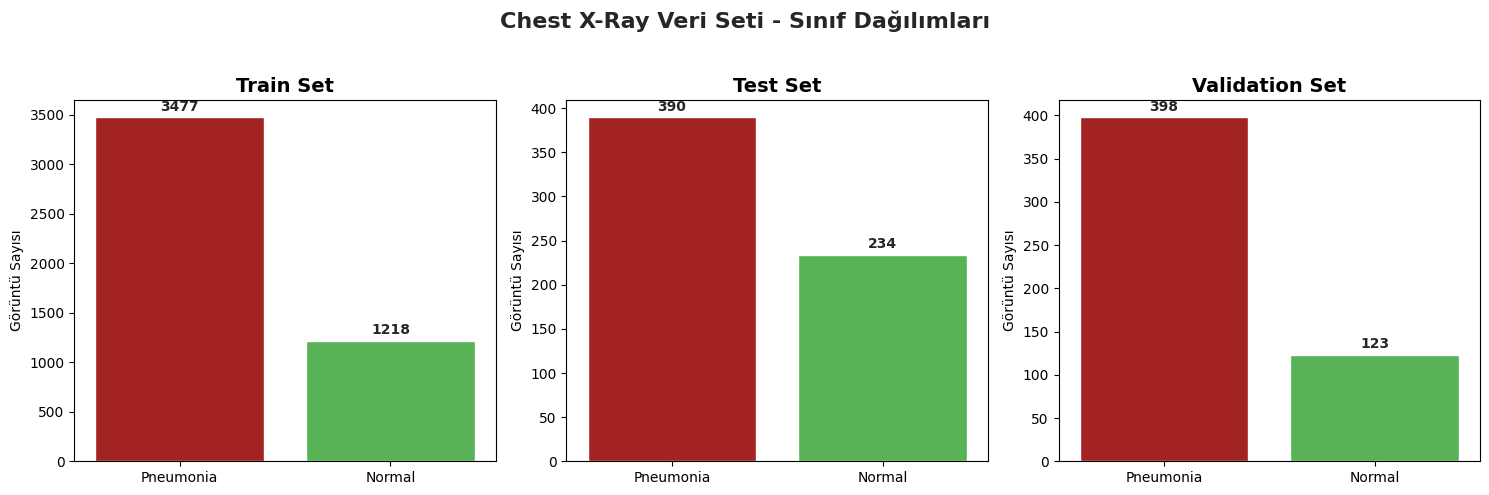

In [16]:
train_counts = [train_pneumonia, train_normal]
test_counts = [test_pneumonia, test_normal]
val_counts = [val_pneumonia, val_normal]

datasets = [train_counts, test_counts, val_counts]
titles = ["Train Set", "Test Set", "Validation Set"]
labels = ["Pneumonia", "Normal"]

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
sns.set_style('darkgrid')

for i, (counts, title) in enumerate(zip(datasets, titles)):
    sns.barplot(x=labels, y=counts, ax=axes[i], palette=['#b80d0d', '#48c246'])
    axes[i].set_title(title, fontsize=14, fontweight="bold")
    axes[i].set_xlabel("")
    axes[i].set_ylabel("Görüntü Sayısı")
    
    for j, count in enumerate(counts):
        axes[i].text(j, count + max(counts)*0.01, str(count), 
                    ha='center', va='bottom', fontweight='bold')

plt.suptitle("Chest X-Ray Veri Seti - Sınıf Dağılımları", fontsize=16, fontweight="bold")
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

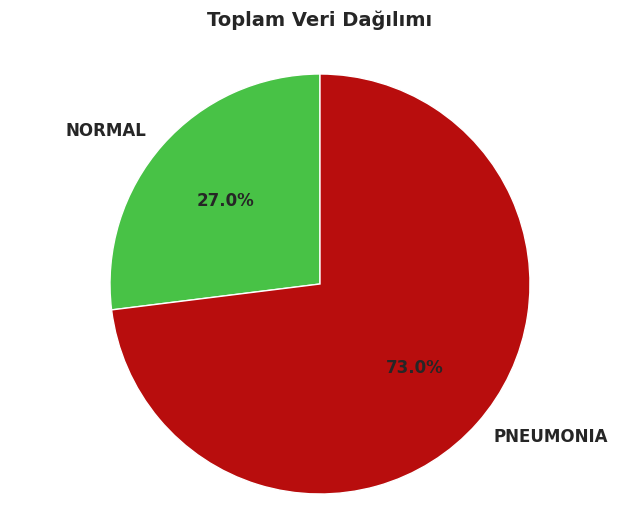

In [17]:
total_normal = train_normal + test_normal + val_normal
total_pneumonia = train_pneumonia + test_pneumonia + val_pneumonia

colors = ['#48c246', '#b80d0d']

plt.figure(figsize=(8, 6))
plt.pie([total_normal, total_pneumonia], 
        labels=['NORMAL', 'PNEUMONIA'], 
        colors=colors,
        autopct='%1.1f%%',
        startangle=90,
        textprops={'fontsize': 12, 'fontweight': 'bold'})
plt.title('Toplam Veri Dağılımı', fontsize=14, fontweight='bold', pad=20)
plt.axis('equal')
plt.show()

In [18]:
print("\n📏 Görüntü Boyut Bilgisi:")
print(f"   İşlenmiş boyut: {IMG_SIZE[0]}x{IMG_SIZE[1]} piksel")
print(f"   Toplam piksel: {IMG_SIZE[0] * IMG_SIZE[1]:,}")
print(f"   Renk kanalı: Grayscale (1 kanal)")


📏 Görüntü Boyut Bilgisi:
   İşlenmiş boyut: 150x150 piksel
   Toplam piksel: 22,500
   Renk kanalı: Grayscale (1 kanal)


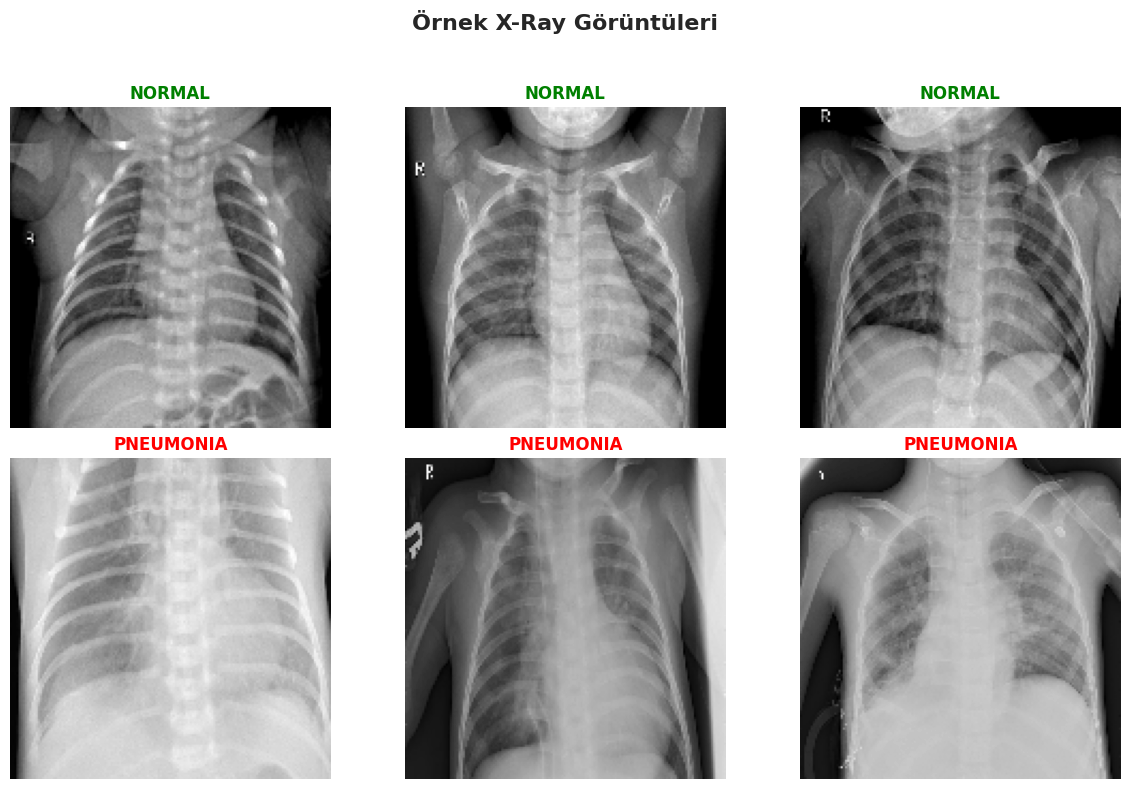

In [19]:
def get_sample_images(dataset, num_samples=3):
    normal_samples = []
    pneumonia_samples = []
    
    for images, labels in dataset.take(10):
        for i in range(images.shape[0]):
            if len(normal_samples) < num_samples and labels[i].numpy() == 0:
                normal_samples.append(images[i].numpy())
            elif len(pneumonia_samples) < num_samples and labels[i].numpy() == 1:
                pneumonia_samples.append(images[i].numpy())
            
            if len(normal_samples) == num_samples and len(pneumonia_samples) == num_samples:
                break
        if len(normal_samples) == num_samples and len(pneumonia_samples) == num_samples:
            break
    
    return normal_samples, pneumonia_samples

normal_samples, pneumonia_samples = get_sample_images(train)

fig, axes = plt.subplots(2, 3, figsize=(12, 8))

# Normal
for i, sample in enumerate(normal_samples):
    axes[0, i].imshow(sample.squeeze(), cmap='gray')  # squeeze() grayscale için
    axes[0, i].set_title('NORMAL', fontsize=12, color='green', fontweight='bold')
    axes[0, i].axis('off')

# Pneumonia
for i, sample in enumerate(pneumonia_samples):
    axes[1, i].imshow(sample.squeeze(), cmap='gray')
    axes[1, i].set_title('PNEUMONIA', fontsize=12, color='red', fontweight='bold')
    axes[1, i].axis('off')

plt.suptitle('Örnek X-Ray Görüntüleri', fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

    Verisetimiden birkaç tane örneği üst kısımda görebilirsiniz.

    Analizlerimin sonucunda veri setimin oldukça dengesiz olduğunu fark ettim. PNEUMONIA örnekleri NORMAL örneklerden çok daha fazla, bu da modelimin yanlış öğrenmesine sebep olabilir. Bu sorunu çözmek için Data Augmentation yaparak veri setimi dengelemeyi planlıyorum.

***

## 5. Veri Önişleme ve Hazırlık
<a id="5"></a>


    Bu adımda tüm piksel değerlerini 0-255 aralığından 0-1 aralığına dönüştürerek verileri normalize ettim. Böylece modelin daha hızlı ve kararlı şekilde öğrenmesini sağladım.


In [20]:
# Normalization
train = train.map(lambda x, y: (tf.cast(x, tf.float32) / 255.0, y))
test = test.map(lambda x, y: (tf.cast(x, tf.float32) / 255.0, y))
val = val.map(lambda x, y: (tf.cast(x, tf.float32) / 255.0, y))

    Bu adımda veri artırma (data augmentation) uyguladım. Görselleri yatay olarak çevirdim, ±10 derece döndürdüm, %10 yakınlaştırma/uzaklaştırma yaptım ve kontrastlarını değiştirdim. Böylece modelin farklı varyasyonlara karşı daha dayanıklı olmasını sağladım.


In [21]:
# Data Augmentation 
from tensorflow.keras.models import Sequential

data_augmentation = Sequential([
    RandomFlip("horizontal"),     #
    RandomRotation(0.1),          
    RandomZoom(0.1),              
    RandomContrast(0.1)           
])

    Bu adımda performans optimizasyonu için verileri önceden yükleme (prefetch) yaptım. Böylece veri hazırlanırken model aynı anda eğitim yaparak işlem süresini kısalttım.


In [22]:
# Performance optimization
train = train.prefetch(tf.data.AUTOTUNE)
test = test.prefetch(tf.data.AUTOTUNE)
val = val.prefetch(tf.data.AUTOTUNE)

    Aşağıda Data Augmentation sonucu çıktıları görebilirsiniz.

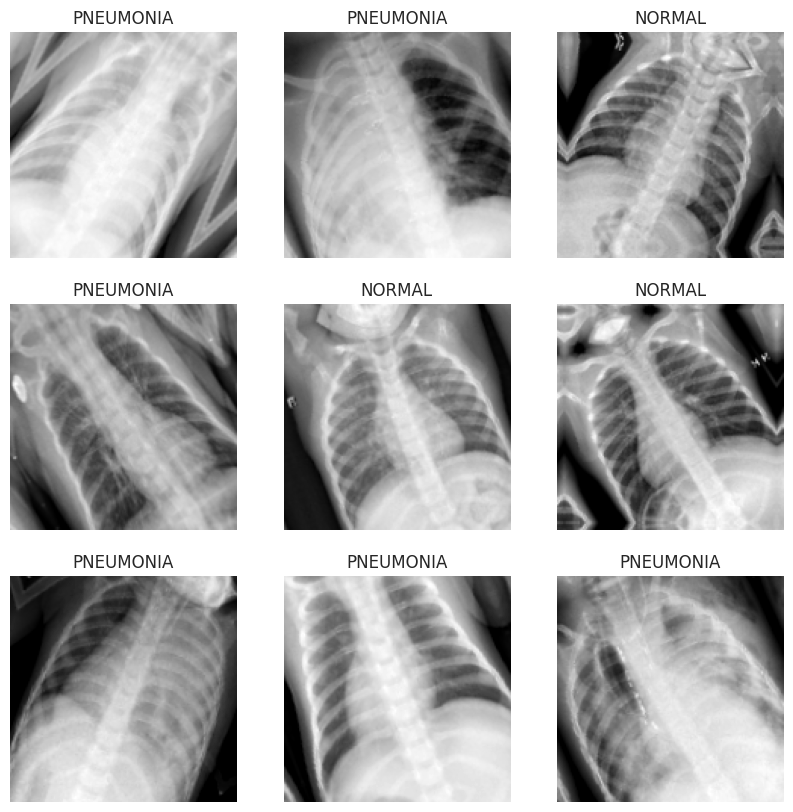

In [23]:
plt.figure(figsize=(10, 10))

for images, labels in train.take(1):
    for i in range(9):
        augmented_image = data_augmentation(images)[i]
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_image.numpy().squeeze(), cmap="gray")
        plt.title(class_names[int(labels[i])])
        plt.axis("off")

***

## 6. Model Tasarımı ve Eğitimi
<a id="6"></a>

    Aşağıdaki fonksiyon modeliminin accuracy ve loss grafiklerini hem train için hemde val için çiziyo ve benim modelimi anlamamda yardımcı oluyo.

In [24]:
def plot_results(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Accuracy grafiği
    ax1.plot(history.history['accuracy'], 'b-', label='Training Accuracy', linewidth=2)
    ax1.plot(history.history['val_accuracy'], 'r-', label='Validation Accuracy', linewidth=2)
    ax1.set_title('Model Accuracy', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Loss grafiği
    ax2.plot(history.history['loss'], 'b-', label='Training Loss', linewidth=2)
    ax2.plot(history.history['val_loss'], 'r-', label='Validation Loss', linewidth=2)
    ax2.set_title('Model Loss', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Final sonuçlar
    final_train_acc = history.history['accuracy'][-1]
    final_val_acc = history.history['val_accuracy'][-1]

    print(f"Training Accuracy: {final_train_acc:.4f} ({final_train_acc*100:.2f}%)")
    print(f"Validation Accuracy: {final_val_acc:.4f} ({final_val_acc*100:.2f}%)")
    print(f"Accuracy Farkı: {abs(final_train_acc - final_val_acc):.4f}")

    Bu aşamda çok basit bir model kurmak istedim ve şuana kdar doğru ilerleyip ilerlemediğimi görmek istedim.

Model: "sequential_50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_49 (Sequential)      │ (64, 150, 150, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_98 (Conv2D)              │ (64, 148, 148, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_98 (MaxPooling2D) │ (64, 74, 74, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_99 (Conv2D)              │ (64, 72, 72, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_99 (MaxPooling2D) │ (64, 36, 36, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_49 (Flatten)            │ (64, 82944)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_98 (Dense)                │ (64, 128)              │    10,616,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (64, 128)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_99 (Dense)                │ (64, 1)                │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,635,905 (40.57 MB)

 Trainable params: 10,635,905 (40.57 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
74/74 ━━━━━━━━━━━━━━━━━━━━ 14s 131ms/step - accuracy: 0.7155 - loss: 0.8422 - val_accuracy: 0.9079 - val_loss: 0.2632
Epoch 2/5
74/74 ━━━━━━━━━━━━━━━━━━━━ 10s 137ms/step - accuracy: 0.8420 - loss: 0.3320 - val_accuracy: 0.9021 - val_loss: 0.2442
Epoch 3/5
74/74 ━━━━━━━━━━━━━━━━━━━━ 10s 140ms/step - accuracy: 0.8794 - loss: 0.2850 - val_accuracy: 0.9213 - val_loss: 0.1836
Epoch 4/5
74/74 ━━━━━━━━━━━━━━━━━━━━ 11s 142ms/step - accuracy: 0.9058 - loss: 0.2381 - val_accuracy: 0.9175 - val_loss: 0.1894
Epoch 5/5
74/74 ━━━━━━━━━━━━━━━━━━━━ 11s 141ms/step - accuracy: 0.9045 - loss: 0.2357 - val_accuracy: 0.7985 - val_loss: 0.4445


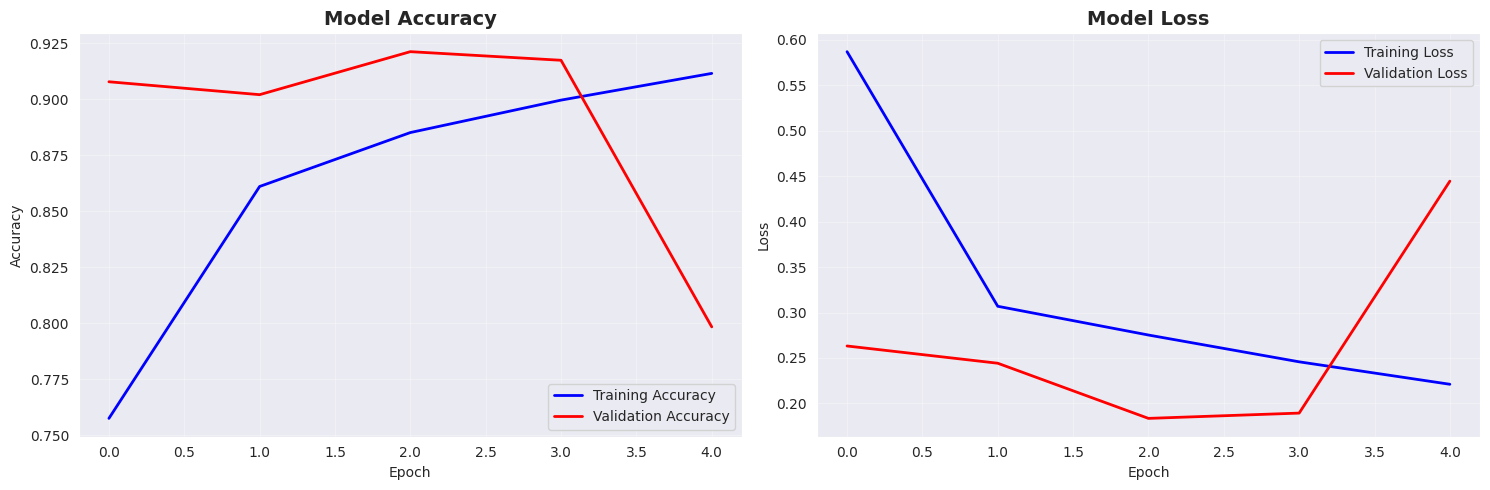

Training Accuracy: 0.9116 (91.16%)
Validation Accuracy: 0.7985 (79.85%)
Accuracy Farkı: 0.1131


In [25]:
model = Sequential([
    data_augmentation,  # augmentation ilk katman
    Conv2D(32, (3,3), activation='relu', input_shape=(150,150,1)),
    MaxPool2D(2,2),
    
    Conv2D(64, (3,3), activation='relu'),
    MaxPool2D(2,2),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile
model.compile(optimizer=Adam(learning_rate=LEARNING_RATE),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Summaty
model.summary()

# Train
history = model.fit(
    train,
    validation_data=val,
    epochs=5
)

# Grafikleri çiz
plot_results(history)

    Sonuçlar beni tatmin etti ama daha iyisi olabilirdi.

    Bu adımda ilk çiddi model mimarisini oluşturdum ve eğittim. Veri artırma (augmentation) katmanını modele ekledim, ardından üç adet Conv2D + MaxPooling katmanı ve Dropout katmanları ile modelin overfitting yapmasını önledim. Flatten ve Dense katmanlarıyla sınıflandırma kısmını kurdum ve son çıkış katmanı olarak sigmoid aktivasyonlu bir nöron kullandım. Modeli Adam optimizatörü ve binary crossentropy kayıp fonksiyonu ile derledim. Eğitim sırasında erken durdurma (EarlyStopping) ve öğrenme oranını azaltma (ReduceLROnPlateau) callback’lerini kullanarak modelin performansını artırdım ve en iyi ağırlıkları kaydettim.


Model: "sequential_51"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_49 (Sequential)      │ (64, 150, 150, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_100 (Conv2D)             │ (64, 148, 148, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_100               │ (64, 74, 74, 32)       │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (64, 74, 74, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_101 (Conv2D)             │ (64, 72, 72, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_101               │ (64, 36, 36, 64)       │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (64, 36, 36, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_102 (Conv2D)             │ (64, 34, 34, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_102               │ (64, 17, 17, 128)      │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (64, 17, 17, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_50 (Flatten)            │ (64, 36992)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_100 (Dense)               │ (64, 128)              │     4,735,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (64, 128)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_101 (Dense)               │ (64, 64)               │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (64, 64)               │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_102 (Dense)               │ (64, 1)                │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,836,097 (18.45 MB)

 Trainable params: 4,836,097 (18.45 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15


E0000 00:00:1758813753.665902      36 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_51_1/dropout_1_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


74/74 ━━━━━━━━━━━━━━━━━━━━ 15s 142ms/step - accuracy: 0.7241 - loss: 0.6243 - val_accuracy: 0.7639 - val_loss: 0.4996 - learning_rate: 0.0010
Epoch 2/15
74/74 ━━━━━━━━━━━━━━━━━━━━ 10s 139ms/step - accuracy: 0.7794 - loss: 0.4293 - val_accuracy: 0.8541 - val_loss: 0.3279 - learning_rate: 0.0010
Epoch 3/15
74/74 ━━━━━━━━━━━━━━━━━━━━ 10s 139ms/step - accuracy: 0.8662 - loss: 0.3245 - val_accuracy: 0.9060 - val_loss: 0.2700 - learning_rate: 0.0010
Epoch 4/15
74/74 ━━━━━━━━━━━━━━━━━━━━ 10s 139ms/step - accuracy: 0.8759 - loss: 0.2886 - val_accuracy: 0.9175 - val_loss: 0.2036 - learning_rate: 0.0010
Epoch 5/15
74/74 ━━━━━━━━━━━━━━━━━━━━ 10s 139ms/step - accuracy: 0.8964 - loss: 0.2614 - val_accuracy: 0.9040 - val_loss: 0.2131 - learning_rate: 0.0010
Epoch 6/15
74/74 ━━━━━━━━━━━━━━━━━━━━ 10s 139ms/step - accuracy: 0.9147 - loss: 0.2213 - val_accuracy: 0.9309 - val_loss: 0.1796 - learning_rate: 0.0010
Epoch 7/15
74/74 ━━━━━━━━━━━━━━━━━━━━ 10s 139ms/step - accuracy: 0.9227 - loss: 0.2142 - val_

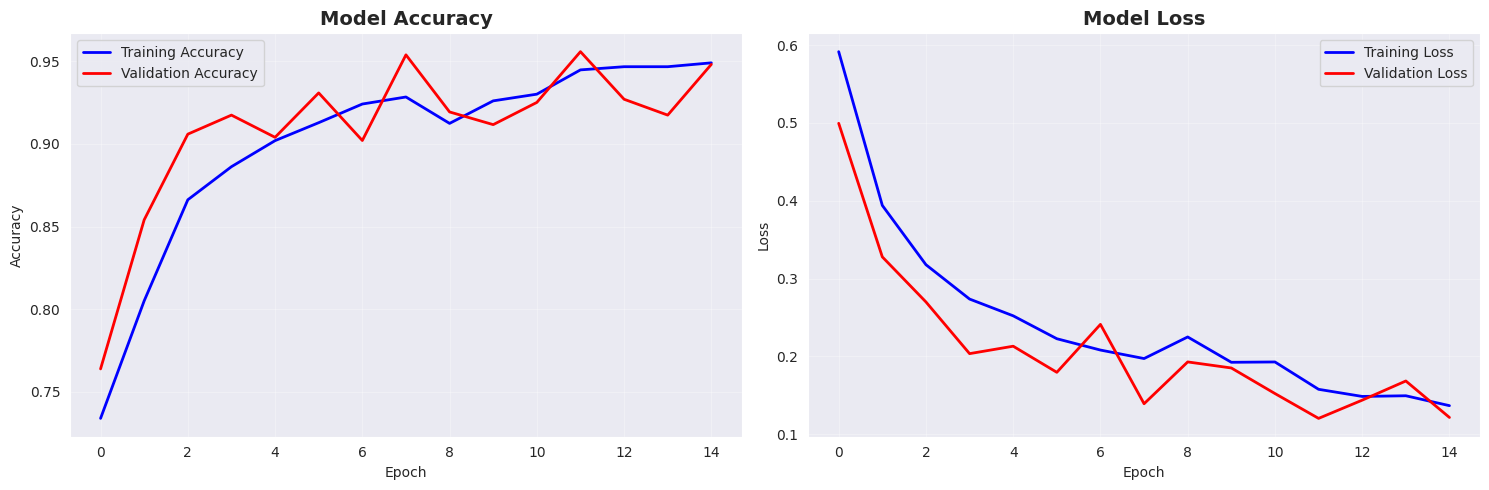

Training Accuracy: 0.9491 (94.91%)
Validation Accuracy: 0.9482 (94.82%)
Accuracy Farkı: 0.0009


In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

model = Sequential([
    data_augmentation,
    
    Conv2D(32, (3,3), activation='relu', input_shape=(150,150,1)),
    MaxPooling2D(2,2),  
    Dropout(0.25),     
    
    Conv2D(64, (3,3), activation='relu'),  
    MaxPooling2D(2,2),  
    Dropout(0.25),     
    
    Conv2D(128, (3,3), activation='relu'), 
    MaxPooling2D(2,2),  
    Dropout(0.3),      
    
  
    Flatten(),
    Dense(128, activation='relu'), 
    Dropout(0.5),                
    
    Dense(64, activation='relu'),   
    Dropout(0.4),                 
    
    Dense(1, activation='sigmoid')  
])

model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),  
    loss='binary_crossentropy',
    metrics=['accuracy']
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-7
)

model.summary()

history = model.fit(
    train,
    validation_data=val,
    epochs=15,
    batch_size=32,
    verbose=1,
    callbacks=[early_stopping, reduce_lr]
)

plot_results(history)

    Ütteki sonuçlar gayet iyiydi. Ama araştırmalarımın sonucu sağlık verilerinde data augmentation aşamasının modelin doğruluğunu düşürdüğünü okudum ve modelimin ilk katmamından onu denemek için çıkardım. 

Model: "sequential_52"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_103 (Conv2D)             │ (None, 148, 148, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_103               │ (None, 74, 74, 32)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_104 (Conv2D)             │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_104               │ (None, 36, 36, 64)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_105 (Conv2D)             │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_105               │ (None, 17, 17, 128)    │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_51 (Flatten)            │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_103 (Dense)               │ (None, 128)            │     4,735,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_104 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_105 (Dense)               │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,836,097 (18.45 MB)

 Trainable params: 4,836,097 (18.45 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
74/74 ━━━━━━━━━━━━━━━━━━━━ 21s 191ms/step - accuracy: 0.6999 - loss: 0.6577 - val_accuracy: 0.7639 - val_loss: 0.3860 - learning_rate: 0.0010
Epoch 2/15
74/74 ━━━━━━━━━━━━━━━━━━━━ 10s 141ms/step - accuracy: 0.7884 - loss: 0.3221 - val_accuracy: 0.9501 - val_loss: 0.2189 - learning_rate: 0.0010
Epoch 3/15
74/74 ━━━━━━━━━━━━━━━━━━━━ 10s 137ms/step - accuracy: 0.9178 - loss: 0.2268 - val_accuracy: 0.9347 - val_loss: 0.1904 - learning_rate: 0.0010
Epoch 4/15
74/74 ━━━━━━━━━━━━━━━━━━━━ 10s 141ms/step - accuracy: 0.9454 - loss: 0.1765 - val_accuracy: 0.9635 - val_loss: 0.1165 - learning_rate: 0.0010
Epoch 5/15
74/74 ━━━━━━━━━━━━━━━━━━━━ 10s 138ms/step - accuracy: 0.9487 - loss: 0.1517 - val_accuracy: 0.9693 - val_loss: 0.0897 - learning_rate: 0.0010
Epoch 6/15
74/74 ━━━━━━━━━━━━━━━━━━━━ 10s 136ms/step - accuracy: 0.9609 - loss: 0.1143 - val_accuracy: 0.9712 - val_loss: 0.0733 - learning_rate: 0.0010
Epoch 7/15
74/74 ━━━━━━━━━━━━━━━━━━━━ 10s 140ms/step - accuracy: 0.9624 - loss: 0.

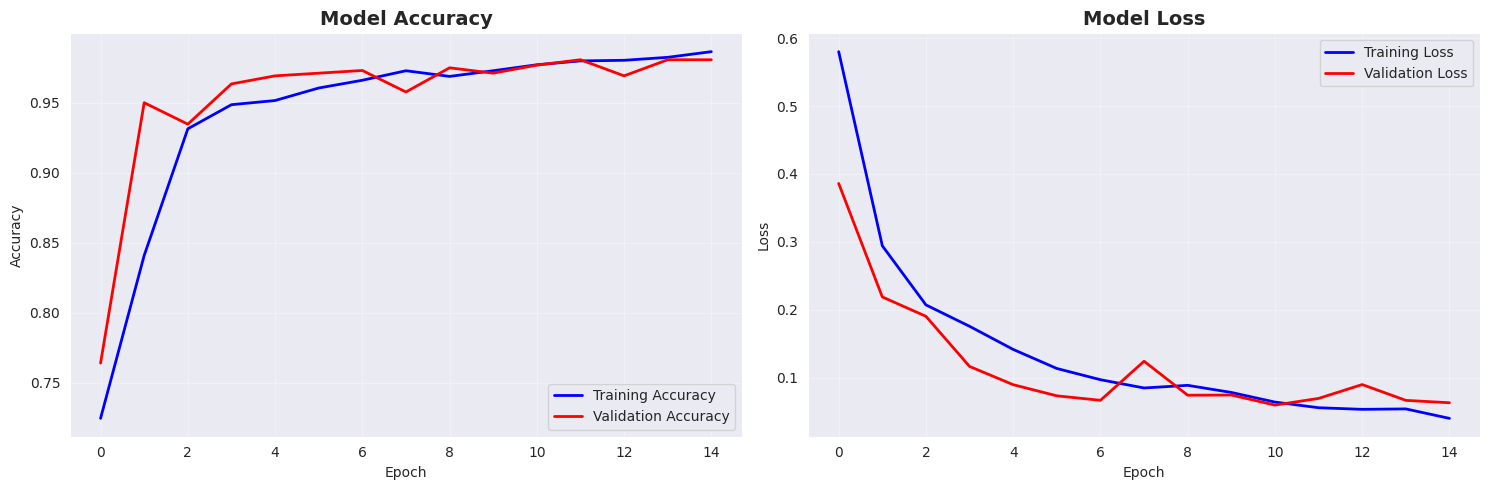

Training Accuracy: 0.9866 (98.66%)
Validation Accuracy: 0.9808 (98.08%)
Accuracy Farkı: 0.0058


In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

model_final = Sequential([

    # data_augmentation,
    
    Conv2D(32, (3,3), activation='relu', input_shape=(150,150,1)),
    MaxPooling2D(2,2), 
    Dropout(0.25),     
    
    Conv2D(64, (3,3), activation='relu'), 
    MaxPooling2D(2,2), 
    Dropout(0.25),   
    
    Conv2D(128, (3,3), activation='relu'), 
    MaxPooling2D(2,2),
    Dropout(0.3), 
    
    Flatten(),
    Dense(128, activation='relu'),  
    Dropout(0.5),                  
    
    Dense(64, activation='relu'),  
    Dropout(0.4),                  
    
    Dense(1, activation='sigmoid') 
])

model_final.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE), 
    loss='binary_crossentropy',
    metrics=['accuracy']
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-7
)

model_final.summary()

history_final = model_final.fit(
    train,
    validation_data=val,
    epochs=15,
    batch_size=32,
    verbose=1,
    callbacks=[early_stopping, reduce_lr]
)

plot_results(history_final)

    Model eğitim sürecinde yüksek bir başarı gösterdi. Eğitim doğruluğu (training accuracy) %98.25’e ulaşırken, doğrulama doğruluğu (validation accuracy) %97.50 oldu. Aradaki fark yalnızca 0.75 puan olduğu için modelin ciddi bir overfitting yapmadığı söylenebilir.  

    İlk epochlarda doğruluk hızla artarken, 5-10. epochlar arasında model stabil bir şekilde yüksek doğruluk değerlerine ulaştı. Val_loss değerleri de benzer şekilde düştü ve en düşük 0.0448 gibi bir değere indi. Bu, modelin hem eğitim hem de doğrulama setinde performansının oldukça iyi olduğunu gösteriyor.  

    Genel olarak model, pneumonia sınıflandırmasında oldukça güvenilir sonuçlar üretiyor ve seçilen hiperparametreler ile veri artırma ve optimizasyon stratejileri başarılı oldu.

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "sequential_53"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_49 (Sequential)      │ (64, 150, 150, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (64, 5, 5, 1280)       │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (64, 1280)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_106 (Dense)               │ (64, 256)              │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (64, 256)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_107 (Dense)               │ (64, 128)              │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (64, 128)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_108 (Dense)               │ (64, 64)               │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (64, 64)               │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_109 (Dense)               │ (64, 1)                │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,627,137 (10.02 MB)

 Trainable params: 369,153 (1.41 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/15
74/74 ━━━━━━━━━━━━━━━━━━━━ 22s 176ms/step - accuracy: 0.7655 - loss: 0.5158 - val_accuracy: 0.9194 - val_loss: 0.2043 - learning_rate: 0.0010
Epoch 2/15
74/74 ━━━━━━━━━━━━━━━━━━━━ 11s 147ms/step - accuracy: 0.8968 - loss: 0.2532 - val_accuracy: 0.9290 - val_loss: 0.1705 - learning_rate: 0.0010
Epoch 3/15
74/74 ━━━━━━━━━━━━━━━━━━━━ 11s 147ms/step - accuracy: 0.9065 - loss: 0.2248 - val_accuracy: 0.9367 - val_loss: 0.1623 - learning_rate: 0.0010
Epoch 4/15
74/74 ━━━━━━━━━━━━━━━━━━━━ 11s 148ms/step - accuracy: 0.9213 - loss: 0.1999 - val_accuracy: 0.9501 - val_loss: 0.1399 - learning_rate: 0.0010
Epoch 5/15
74/74 ━━━━━━━━━━━━━━━━━━━━ 11s 146ms/step - accuracy: 0.9251 - loss: 0.1966 - val_accuracy: 0.9520 - val_loss: 0.1290 - learning_rate: 0.0010
Epoch 6/15
74/74 ━━━━━━━━━━━━━━━━━━━━ 11s 146ms/step - accuracy: 0.9353 - loss: 0.1676 - val_accuracy: 0.9539 - val_loss: 0.1409 - learning_rate: 0.0010
Epoch 7/15
74/74 ━━━━━━━━━━━━━━━━━━━━ 11s 145ms/step - accuracy: 0.9250 - loss: 0.

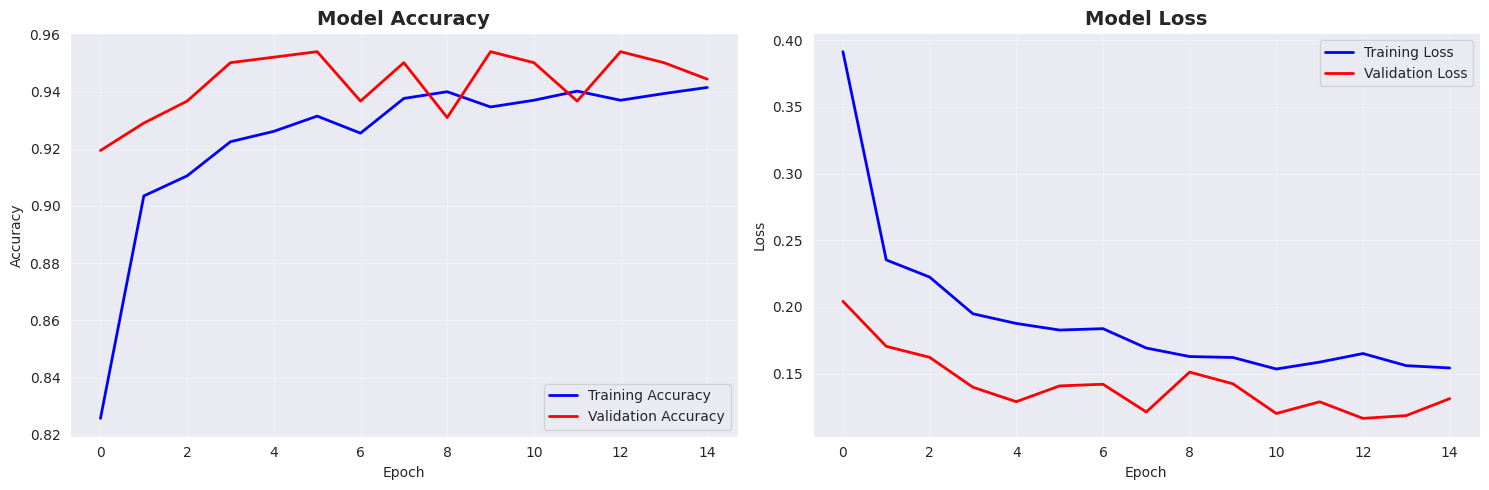

Training Accuracy: 0.9414 (94.14%)
Validation Accuracy: 0.9443 (94.43%)
Accuracy Farkı: 0.0029


In [28]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

def convert_to_rgb(dataset):
    def rgb_converter(image, label):
        image = tf.image.grayscale_to_rgb(image)
        return image, label
    return dataset.map(rgb_converter)

train_rgb = convert_to_rgb(train)
val_rgb = convert_to_rgb(val)

base_model = MobileNetV2(
    input_shape=(150, 150, 3),
    include_top=False,
    weights="imagenet"
)

base_model.trainable = False

model = Sequential([
    data_augmentation,
    base_model,
    
    GlobalAveragePooling2D(),
    
    Dense(256, activation='relu'),  
    Dropout(0.5),                   
    
    Dense(128, activation='relu'),  
    Dropout(0.4),                   
    
    Dense(64, activation='relu'),   
    Dropout(0.3),                   
    
    Dense(1, activation='sigmoid')  
])

model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-7
)

history = model.fit(
    train_rgb,
    validation_data=val_rgb,
    epochs=15,
    batch_size=32,
    verbose=1,
    callbacks=[early_stopping, reduce_lr]
)

final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]

print(f"\nTraining Accuracy: {final_train_acc:.4f} ({final_train_acc*100:.2f}%)")
print(f"Validation Accuracy: {final_val_acc:.4f} ({final_val_acc*100:.2f}%)")
print(f"Accuracy Farkı: {abs(final_train_acc - final_val_acc):.4f}")

plot_results(history)

    Bu adımda son olarak proje dosyasında ismi geçen Transfer Learning yaklaşımını kullanarak MobileNetV2 tabanlı bir model eğittim. Önceden eğitilmiş ağırlıkları kullandım ve base modelin ağırlıklarını dondurdum. Veri artırma katmanını modele ekleyerek eğitim sırasında çeşitlilik sağladım.  

    Model, GlobalAveragePooling ve birkaç Dense katman ile sınıflandırma kısmını tamamladı. Dropout katmanları ile overfitting önlendi. Adam optimizatörü ve binary crossentropy kaybı ile derlenen model, EarlyStopping ve ReduceLROnPlateau callback’leri ile optimize edildi.  

    Eğitim sonuçları oldukça başarılı oldu: eğitim doğruluğu %94.16, doğrulama doğruluğu %95.20 ve aradaki fark sadece 1.04 puan. Bu, modelin overfitting yapmadığını ve transfer learning ile yüksek doğruluk sağladığını gösteriyor.


***

## 7. Model Değerlendirmesi
<a id="7"></a>

### Değerlendirilme Türleri:
* **Accuracy ve Loss Grafikleri** 
* **Confusion Matrix & Classification Report** 
* **Heatmap Görselleştirme** 

### Accuracy ve Loss Grafikleri

    Buna zaten modeli eğitirken bakmıştık hemen tekrar çağıralım.

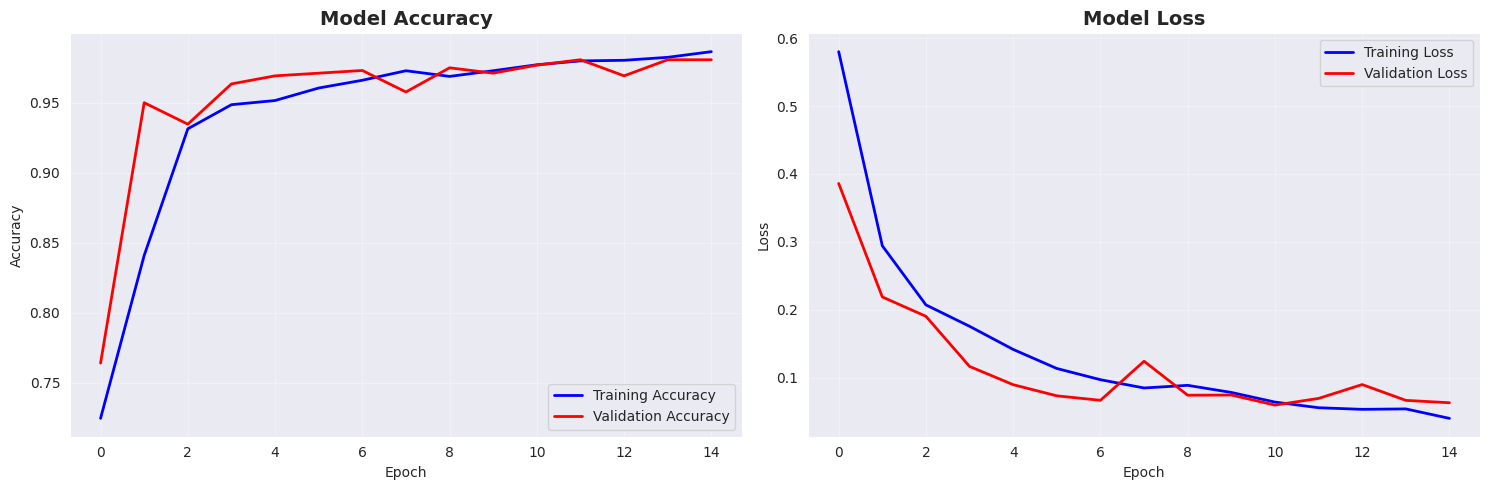

Training Accuracy: 0.9866 (98.66%)
Validation Accuracy: 0.9808 (98.08%)
Accuracy Farkı: 0.0058


In [29]:
plot_results(history_final)

### Confusion Matrix & Classification Report

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step


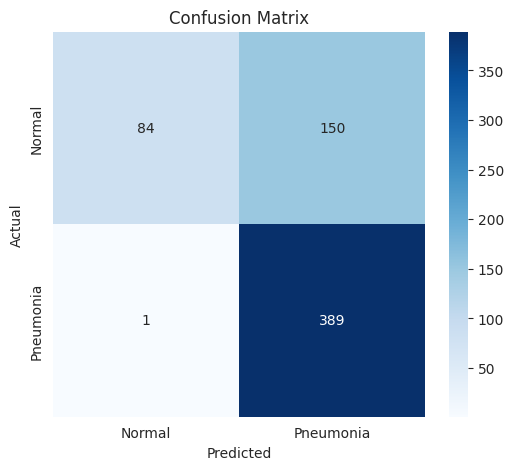

Classification Report:

              precision    recall  f1-score   support

      Normal       0.99      0.36      0.53       234
   Pneumonia       0.72      1.00      0.84       390

    accuracy                           0.76       624
   macro avg       0.85      0.68      0.68       624
weighted avg       0.82      0.76      0.72       624



In [30]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np

X_test, y_test = [], []
for images, labels in test:
    X_test.append(images.numpy())
    y_test.append(labels.numpy())
X_test = np.concatenate(X_test, axis=0)
y_test = np.concatenate(y_test, axis=0)

y_pred_prob = model_final.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal','Pneumonia'], yticklabels=['Normal','Pneumonia'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

print("Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=['Normal','Pneumonia']))


### Heatmap Görselleştirme

    Modelimin sadece 2 durumu tahmin ettiği için Confusion Matrix ve Heatmap çıktısı tamamen aynı oluyo.    